In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from generative_model import WGAN_SIMPLE, eval_model, sample_z
from process_data import load_csv_with_cache, MinMaxScaler
from plotting import plot_mean_std, plot_distribution, plot_slice
from configs import DATA_ROOT, MODEL_ROOT, data_paths, model_paths

# paths
from glob import glob

# computation
import numpy as np
import pandas as pd
import torch

# graphing
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = load_csv_with_cache(f'{DATA_ROOT}/Rayleigh_P30_downsampled_flat.csv')
cord = load_csv_with_cache(f'{DATA_ROOT}/downsampled_points.csv')
avg = np.mean(data, axis=0)

scaler = MinMaxScaler()
scaler.fit(data)

normed_data = scaler.transform(data)
n_features = normed_data.shape[1]

<Axes: ylabel='Count'>

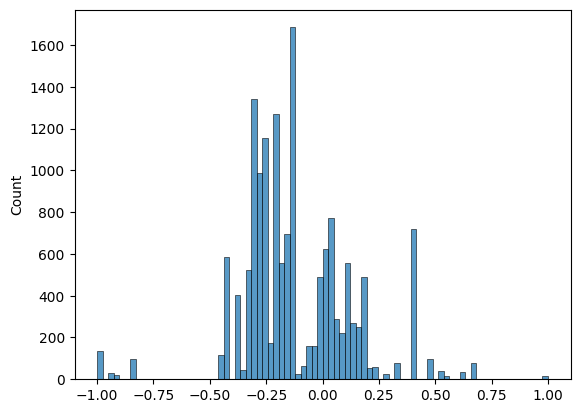

In [4]:
sns.histplot(normed_data[:, 0])

In [5]:
point = cord[1333]
neighbors = np.argsort(np.linalg.norm(cord - point, axis=1))[:7]
point, cord[neighbors], neighbors

(array([ 7.75991461, 32.44104792]),
 array([[ 7.75991461, 32.44104792],
        [ 8.14120745, 31.45852338],
        [ 7.36958999, 33.42277974],
        [ 8.93061649, 32.36536762],
        [ 6.58675715, 32.50625907],
        [ 6.98160328, 31.52709296],
        [ 8.5541283 , 33.35011859]]),
 array([1333, 2344, 1034, 2319,  734,  555,  531]))

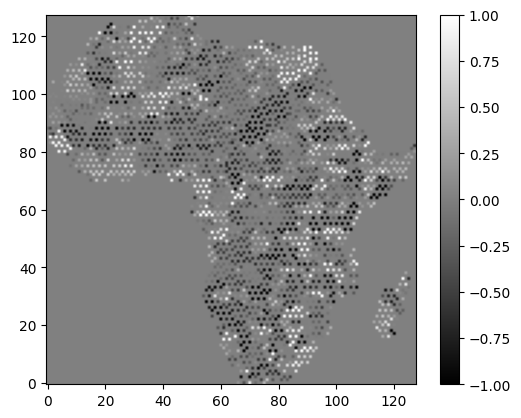

In [8]:
# sns.jointplot(pd.DataFrame({'x': cord[:, 0], 'y': cord[:, 1]}),
#              x='x', y='y', marginal_kws=dict(bins=512), marginal_ticks=True)
xmin, xmax = cord[:, 0].min(), cord[:, 0].max()
ymin, ymax = cord[:, 1].min(), cord[:, 1].max()
bins = 128
xtick = (xmax + 0.001 - xmin) / bins
ytick = (ymax + 0.001 - ymin) / bins
arr = np.zeros((bins, bins))
cord_2d = np.zeros((2382, 2), dtype=int)
for i, ((x, y), val) in enumerate(zip(cord, normed_data[0])):
    x, y = int((x - xmin) / xtick), int((y - ymin) / ytick)
    assert arr[y, x] == 0, f'arr[{y}, {x}] = {arr[y, x]} != 0'
    arr[y, x] = val
    cord_2d[i] = (x, y)

plt.imshow(arr, cmap='gray', origin='lower')
plt.colorbar()

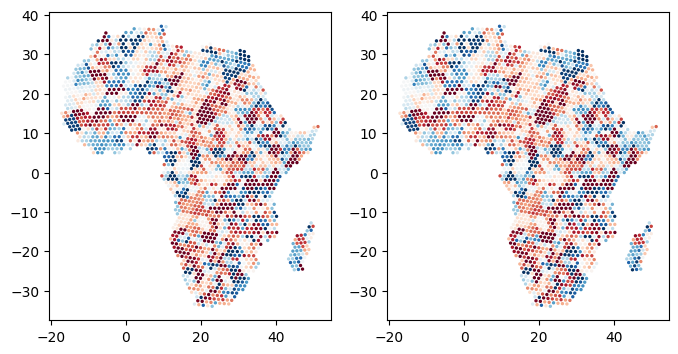

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax0, ax1 = axes.flatten()
ax0.scatter(cord[:, 0], cord[:, 1], c=normed_data[0, :],
            vmin=-1, vmax=1, cmap='RdBu', s=2)
ax1.scatter(cord[:, 0], cord[:, 1], c=normed_data[1, :],
            vmin=-1, vmax=1, cmap='RdBu', s=2)

In [10]:
from IPython.display import display, clear_output

%matplotlib inline
# %matplotlib notebook

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for x, y, c in zip(cord[:, 0], cord[:, 1], np.arange(2382) / 2382):
    ax.scatter(x, y, c=c)
    display(fig)
    clear_output(wait=True)
    plt.pause(0.0001)

KeyboardInterrupt: 

## Model testing


In [5]:
model = WGAN_SIMPLE(nhid=200, uniform_z=False)
checkpoint = torch.load(f'{MODEL_ROOT}/WGAN_SIMPLE_epoch199.model')
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'gen_optimizer_state_dict', 'dist_optimizer_state_dict'])

In [6]:
checkpoint['epoch']

199

In [8]:
checkpoint['dist_optimizer_state_dict']

{'state': {0: {'step': 72200,
   'exp_avg': tensor([[-0.0008, -0.0057,  0.0005,  ..., -0.0001,  0.0028, -0.0008],
           [ 0.0024,  0.0028,  0.0032,  ...,  0.0085,  0.0090,  0.0028],
           [-0.0002,  0.0007,  0.0004,  ...,  0.0019,  0.0038,  0.0027],
           ...,
           [-0.0016, -0.0007,  0.0002,  ..., -0.0011, -0.0019, -0.0002],
           [-0.0014,  0.0022,  0.0007,  ..., -0.0006, -0.0016,  0.0048],
           [ 0.0006,  0.0012,  0.0025,  ...,  0.0036,  0.0032,  0.0021]]),
   'exp_avg_sq': tensor([[2.9275e-05, 5.9585e-05, 5.7245e-05,  ..., 2.8335e-04, 2.7019e-04,
            2.0559e-04],
           [1.3946e-05, 3.0315e-05, 1.7948e-05,  ..., 1.0652e-04, 9.5781e-05,
            9.3030e-05],
           [3.1585e-06, 7.7718e-06, 5.6920e-06,  ..., 2.9232e-05, 3.9139e-05,
            2.2756e-05],
           ...,
           [4.8179e-06, 7.8083e-06, 6.7466e-06,  ..., 3.9596e-05, 4.6581e-05,
            3.1612e-05],
           [1.0825e-05, 2.2855e-05, 1.6488e-05,  ..., 6.7556e